# Iterative Deconvolution of NET-seq Signal

Richardson-Lucy-style iterative scheme to extract the true RNAP dwell time profile $D(x)$ from the observed NET-seq signal $S_{\text{exp}}(x)$, using repeated TASEP simulations.

**Core idea:** $S(x) = D(x) \cdot j(x)$, where $j(x)$ is the position-dependent RNAP flux that decays along the gene due to Rho-dependent premature termination. The iteration finds $D^*(x)$ such that $\text{TASEP}(D^*) \approx S_{\text{exp}}$.

**Key result:** Converges to a dwell-time solution that doesn't replicate the experimental NETSEQ data when fed into the TASEP simulator. This is because the problem is inherently nonlinear, and RL iterative deconvolution only works with linear deconvolution problems. That is, j(x) and D(x) are inherently nonseparable.

In [15]:
import os
import time
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

from netseq_tasep_fast import (
    netseq_tasep_fast,
    _load_gene_parameters,
)

## Parameters

Edit the cell below to configure the deconvolution run.

In [16]:
# --- Deconvolution parameters ---
gene = "insQ"          # Gene name (must match NETSEQ_gene/NETSEQ_<gene>.csv)
n_runs = 300           # TASEP simulations per iteration
max_iter = 50          # Maximum RL iterations
alpha = 0.5            # Damping exponent for multiplicative update
tol = 0.01             # Convergence tolerance on relative D change
floor_val = 0.05       # Minimum denominator for S_sim_norm (prevents division blow-up)
ratio_cap = 10         # Maximum multiplicative correction per iteration
patience = 3           # Iterations without best-residual improvement before stopping
seed = None            # Set to integer (e.g. 42) for reproducible runs

# --- Flux correction parameters (Eq. M3) ---
j_floor = 0.01         # Minimum flux for regularization (prevents division blow-up at 3' end)

## Data Loading

In [17]:
# Load gene-specific parameters (S_exp as dwell profile, kRiboLoading, KRutLoading)
base_params = _load_gene_parameters(gene)

# The loaded dwell profile IS S_exp normalized to mean=1
S_exp_norm = base_params["RNAP_dwellTimeProfile"].copy()
gene_length = len(S_exp_norm)
K_Rut = base_params["KRutLoading"]
kRiboLoading = base_params["kRiboLoading"]

print(f"Gene: {gene}")
print(f"Gene length: {gene_length} bp")
print(f"KRutLoading: {K_Rut}")
print(f"kRiboLoading: {kRiboLoading:.4f} (TE/5)")

Gene: insQ
Gene length: 1149 bp
KRutLoading: 0.13
kRiboLoading: 0.0220 (TE/5)


## Test 1: Approximate Initial Dwell Time Estimation via Analytical Flux Correction (Eq. M3)

The naive initialization $D^0 = S_{\text{exp}} / \text{mean}(S_{\text{exp}})$ assumes constant flux $j(x) = \text{const}$, which systematically underestimates dwell times downstream. Instead, we use the first-order analytical flux correction:

$$j_{\text{shape}}(x) = \exp\!\left(-\frac{K_{\text{Rut}}}{2L}\,(x - \ell_0)^2\right) \quad \text{for } x > \ell_0, \quad \text{else } 1.0$$

where $\ell_0 = \ell_{\text{RNAP}}(35) + \ell_{\min}(50) = 85$ bp.

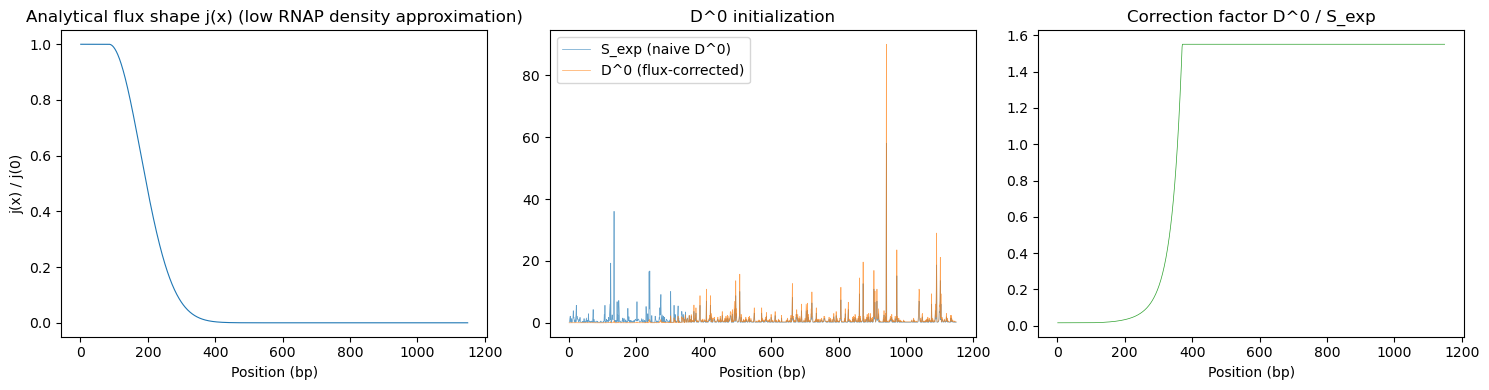

In [18]:
# Eq. M3: Gaussian flux shape from Rho termination model
ell_0 = 35 + 50  # ell_RNAP + ell_min = 85 bp
x = np.arange(1, gene_length + 1, dtype=float)

j_shape = np.ones(gene_length)
mask = x > ell_0
j_shape[mask] = np.exp(-K_Rut / (2 * gene_length) * (x[mask] - ell_0) ** 2)

# Regularize to avoid division blow-up at 3' end
j_shape_reg = np.maximum(j_shape, j_floor)

# Flux-correct: D_corrected = S_exp / j_shape_reg, then normalize to mean=1
D_corrected = S_exp_norm / j_shape_reg
D_current = D_corrected / np.mean(D_corrected)

# Visualize the initialization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(x, j_shape, lw=0.8)
axes[0].set_title("Analytical flux shape j(x) (low RNAP density approximation)")
axes[0].set_xlabel("Position (bp)")
axes[0].set_ylabel("j(x) / j(0)")

axes[1].plot(x, S_exp_norm, lw=0.5, alpha=0.7, label="S_exp (naive D^0)")
axes[1].plot(x, D_current, lw=0.5, alpha=0.7, label="D^0 (flux-corrected)")
axes[1].set_title("D^0 initialization")
axes[1].set_xlabel("Position (bp)")
axes[1].legend()

axes[2].plot(x, D_current / S_exp_norm, lw=0.5, color="tab:green")
axes[2].set_title("Correction factor D^0 / S_exp")
axes[2].set_xlabel("Position (bp)")

plt.tight_layout()
plt.show()

## Test 2: Naive initilaization

Just load with $D^0 = S_{\text{exp}} / \text{mean}(S_{\text{exp}})$. Uncomment the Python code below if you want to test

In [19]:
# D_current = S_exp_norm

## RL Iteration Loop

Bounded multiplicative update:
$$\text{ratio}_n(x) = \text{clip}\!\left(\frac{S_{\text{exp,norm}}(x)}{\max(S_{\text{sim,norm}}^n(x),\, \text{floor})}, \; \frac{1}{\text{ratio\_cap}}, \; \text{ratio\_cap}\right)$$
$$D^{(n+1)}(x) = D^n(x) \cdot \text{ratio}_n(x)^\alpha$$

In [ ]:
def run_simulations_with_dwell(dwell_profile, base_params, n_runs, base_seed, n_workers=None):
    """Run n_runs TASEP simulations with a custom dwell profile and return mean NETseq_sum."""
    params = dict(base_params)
    params["RNAP_dwellTimeProfile"] = dwell_profile

    seeds = [base_seed + i for i in range(n_runs)]
    if n_workers is None:
        n_workers = os.cpu_count() or 1

    def worker(s):
        result = netseq_tasep_fast(params, seed=s)
        return np.asarray(result["NETseq_sum"], dtype=float)

    if n_workers <= 1:
        outputs = [worker(s) for s in seeds]
    else:
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            outputs = list(executor.map(worker, seeds))

    netseq_total = np.zeros_like(outputs[0], dtype=float)
    for output in outputs:
        netseq_total += output
    return netseq_total / float(n_runs)

def run_rl_deconvolution(gene_name, n_runs=300, max_iter=50, alpha=0.5, tol=0.01,
                         floor_val=0.05, ratio_cap=10, seed=None):
    """Run RL-style iterative deconvolution for a given gene. Returns a results dict."""
    params = _load_gene_parameters(gene_name)
    S_exp = params["RNAP_dwellTimeProfile"].copy()
    gl = len(S_exp)

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    D_current = S_exp.copy()  # naive initialization: D^0 = S_exp_norm
    residuals = []
    rel_changes = []
    D_hist = [D_current.copy()]
    best_res = np.inf
    best_it = -1
    D_best = D_current.copy()
    S_sim_best = None
    S_sim_final = None
    stop = "max_iter reached"
    t0 = time.time()

    for it in range(max_iter):
        S_sim = run_simulations_with_dwell(D_current, params, n_runs, int(rng.integers(0, 2**31)))
        S_sim_mean = np.mean(S_sim)
        S_sim_norm = S_sim / S_sim_mean if S_sim_mean > 0 else np.ones_like(S_sim)
        S_sim_final = S_sim_norm.copy()

        res = np.sqrt(np.mean((S_exp - S_sim_norm) ** 2))
        residuals.append(res)
        if res < best_res:
            best_res, best_it = res, it
            D_best = D_current.copy()
            S_sim_best = S_sim_norm.copy()

        # Bounded multiplicative update
        ratio = S_exp / np.maximum(S_sim_norm, floor_val)
        ratio = np.clip(ratio, 1.0 / ratio_cap, ratio_cap)
        D_new = D_current * (ratio ** alpha)
        D_new = D_new / np.mean(D_new)

        rc = np.linalg.norm(D_new - D_current) / np.linalg.norm(D_current)
        rel_changes.append(rc)
        elapsed = time.time() - t0
        print(f"  {gene_name} iter {it}: residual={res:.4f}  best={best_res:.4f} (iter {best_it})  rel_change={rc:.6f}  [{elapsed:.1f}s]")

        if rc < tol:
            stop = f"convergence (rel_change={rc:.6f} < {tol})"
            D_current = D_new
            D_hist.append(D_current.copy())
            break
        D_current = D_new
        D_hist.append(D_current.copy())

    total = time.time() - t0
    print(f"  {gene_name} done: {len(residuals)} iters, {len(residuals)*n_runs} sim calls, {total:.1f}s — {stop}\n")
    return {
        "gene": gene_name, "gene_length": gl, "te": params["kRiboLoading"] * 5,
        "kRiboLoading": params["kRiboLoading"],
        "residuals": residuals, "rel_changes": rel_changes,
        "best_residual": best_res, "best_iter": best_it,
        "D_best": D_best, "S_sim_best": S_sim_best, "S_sim_final": S_sim_final,
        "S_exp": S_exp, "D_history": D_hist, "stop_reason": stop,
    }

In [21]:
# --- Runtime diagnostics ---
total_sim_calls = n_runs * max_iter
print(f"Estimated simulator calls: {n_runs} runs x {max_iter} iterations = {total_sim_calls}")
if total_sim_calls > 1000:
    print(f"WARNING: {total_sim_calls} simulator calls may take substantial runtime.")

# --- Seed management ---
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

# --- Tracking ---
residual_history = []
D_history = [D_current.copy()]
best_residual = np.inf
best_iter = -1
D_best = D_current.copy()
S_sim_best = None
no_improve_count = 0
stop_reason = "max_iter reached"

t_start = time.time()

for iteration in range(max_iter):
    iter_seed = int(rng.integers(0, 2**31))

    # Run TASEP with current D estimate
    S_sim = run_simulations_with_dwell(D_current, base_params, n_runs, iter_seed)

    # Normalize S_sim to mean=1
    S_sim_mean = np.mean(S_sim)
    if S_sim_mean > 0:
        S_sim_norm = S_sim / S_sim_mean
    else:
        S_sim_norm = np.ones_like(S_sim)

    # Compute residual (L2 norm of normalized difference)
    residual = np.sqrt(np.mean((S_exp_norm - S_sim_norm) ** 2))
    residual_history.append(residual)

    # Track best iteration
    if residual < best_residual:
        best_residual = residual
        best_iter = iteration
        D_best = D_current.copy()
        S_sim_best = S_sim_norm.copy()
        no_improve_count = 0
    else:
        no_improve_count += 1

    elapsed = time.time() - t_start
    

    # --- Stopping checks ---
    # Patience-based: no improvement for `patience` consecutive iterations
    # if no_improve_count >= patience:
    #     stop_reason = f"patience ({patience} iters without improvement)"
    #     print(f"  Stopping: {stop_reason}")
    #     break

    # --- Bounded multiplicative update ---
    S_sim_clamped = np.maximum(S_sim_norm, floor_val)
    ratio = S_exp_norm / S_sim_clamped
    ratio_clipped = np.clip(ratio, 1.0 / ratio_cap, ratio_cap)
    D_new = D_current * (ratio_clipped ** alpha)
    D_new = D_new / np.mean(D_new)  # Re-normalize to mean=1

    # Convergence tolerance check
    rel_change = np.linalg.norm(D_new - D_current) / np.linalg.norm(D_current)
    print(f"  iter {iteration}: residual={residual:.6f}  best={best_residual:.6f} (iter {best_iter})  [{elapsed:.1f}s], dwell_time_rel_change={rel_change:.6f}")
    if rel_change < tol:
        stop_reason = f"convergence (rel_change={rel_change:.6f} < tol={tol})"
        D_current = D_new
        D_history.append(D_current.copy())
        print(f"  Stopping: {stop_reason}")
        break

    D_current = D_new
    D_history.append(D_current.copy())

total_time = time.time() - t_start
print(f"\nDone in {total_time:.1f}s ({len(residual_history)} iterations, {len(residual_history) * n_runs} simulator calls)")

Estimated simulator calls: 300 runs x 50 iterations = 15000
  iter 0: residual=3.478213  best=3.478213 (iter 0)  [1.5s], dwell_time_rel_change=0.541864
  iter 1: residual=3.926814  best=3.478213 (iter 0)  [3.0s], dwell_time_rel_change=0.243272
  iter 2: residual=4.378331  best=3.478213 (iter 0)  [4.7s], dwell_time_rel_change=0.117632
  iter 3: residual=4.814879  best=3.478213 (iter 0)  [6.8s], dwell_time_rel_change=0.065617
  iter 4: residual=4.890903  best=3.478213 (iter 0)  [8.6s], dwell_time_rel_change=0.044501
  iter 5: residual=5.089968  best=3.478213 (iter 0)  [10.4s], dwell_time_rel_change=0.033102
  iter 6: residual=5.063811  best=3.478213 (iter 0)  [12.3s], dwell_time_rel_change=0.018764
  iter 7: residual=4.921175  best=3.478213 (iter 0)  [14.1s], dwell_time_rel_change=0.028736
  iter 8: residual=5.318232  best=3.478213 (iter 0)  [16.5s], dwell_time_rel_change=0.016630
  iter 9: residual=5.177847  best=3.478213 (iter 0)  [18.4s], dwell_time_rel_change=0.014326
  iter 10: resi

## Convergence Plot

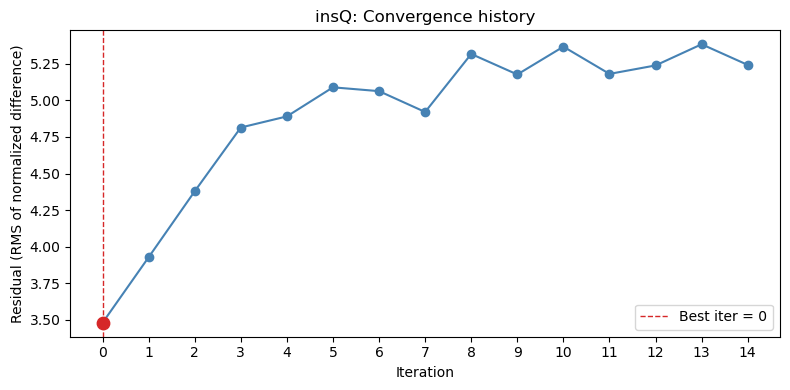

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
iters = np.arange(len(residual_history))
ax.plot(iters, residual_history, "o-", color="steelblue", lw=1.5, markersize=6)
ax.axvline(best_iter, color="tab:red", ls="--", lw=1, label=f"Best iter = {best_iter}")
ax.scatter([best_iter], [best_residual], color="tab:red", s=80, zorder=5)
ax.set_xlabel("Iteration")
ax.set_ylabel("Residual (RMS of normalized difference)")
ax.set_title(f"{gene}: Convergence history")
ax.legend()
ax.set_xticks(iters)
plt.tight_layout()
plt.show()

## Comparison: S_exp vs S_sim (best iteration)

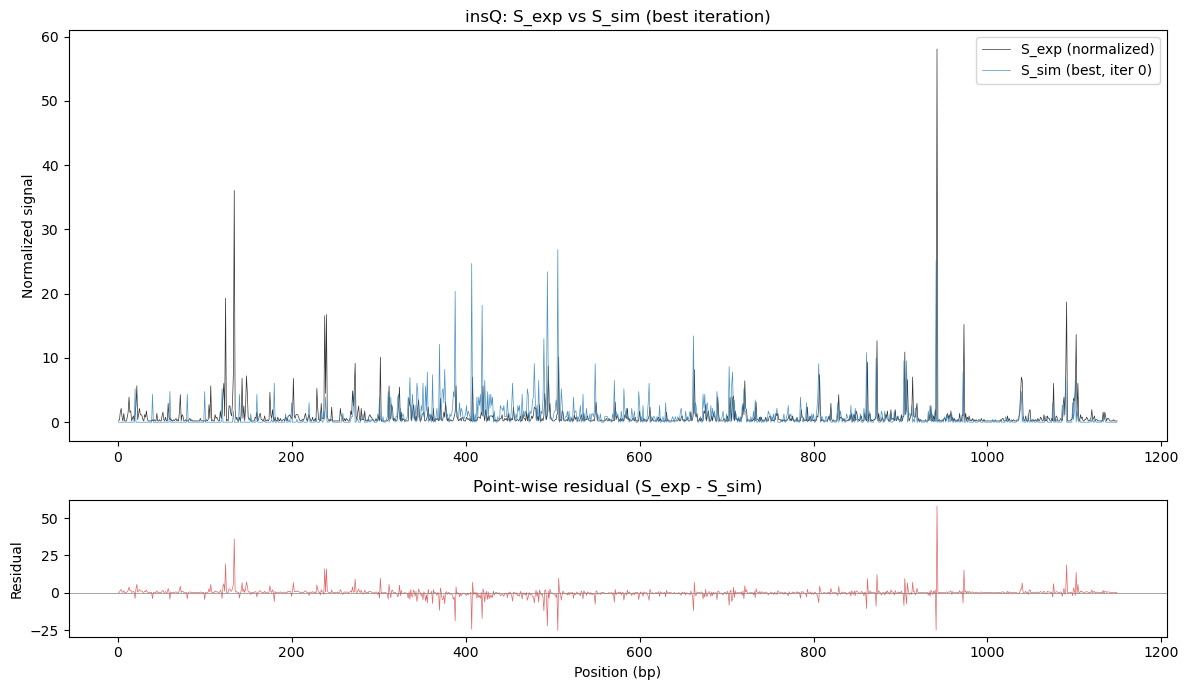

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={"height_ratios": [3, 1]})

pos = np.arange(1, gene_length + 1)
axes[0].plot(pos, S_exp_norm, lw=0.5, alpha=0.8, label="S_exp (normalized)", color="black")
axes[0].plot(pos, S_sim_best, lw=0.5, alpha=0.8, label=f"S_sim (best, iter {best_iter})", color="tab:blue")
axes[0].set_ylabel("Normalized signal")
axes[0].set_title(f"{gene}: S_exp vs S_sim (best iteration)")
axes[0].legend()

axes[1].plot(pos, S_exp_norm - S_sim_best, lw=0.5, color="tab:red", alpha=0.7)
axes[1].axhline(0, color="gray", ls="-", lw=0.5)
axes[1].set_xlabel("Position (bp)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Point-wise residual (S_exp - S_sim)")

plt.tight_layout()
plt.show()

## High-TE Gene Comparison: Testing the Ribosome Protection Hypothesis

The RL iteration on insQ (TE=0.11, kRiboLoading=0.022) showed residual *increasing* from iteration 0. The analysis in EXPLORATION.md identifies two flux-reducing feedback channels that cause this self-defeating behavior:

1. **Exclusion**: boosting D downstream creates traffic jams that redistribute occupancy
2. **Rho on unprotected RNAPs**: slower transit gives Rho more loading opportunities per position (rate process)

A third channel — **ribosome-RNAP coupling** — works in the *opposite* direction: when ribosomes catch the RNAP, they shrink the exposed RNA gap, suppressing Rho loading and *protecting* flux. For insQ this effect is negligible (most RNAPs lack ribosomes), but for high-TE genes it should be strong.

**Prediction**: The RL iteration should converge better (smaller or no residual increase) for genes with high translation efficiency, because ribosome protection weakens the nonlinear backlash.

**Test genes** (highest TE in `Ecoli_gene_TE.csv` with NET-seq data available):

| Gene | TE | kRiboLoading (TE/5) | Length (bp) | vs insQ |
|------|----|---------------------|-------------|---------|
| **yjdM** | 5.11 | 1.022 | 336 | 46x higher TE, short gene |
| **azoR** | 4.28 | 0.856 | 606 | 39x higher TE, moderate length |
| **gpmA** | 3.76 | 0.752 | 753 | 34x higher TE, longest available |

All three have kRiboLoading ~0.75-1.0, meaning ribosomes load frequently enough that most RNAPs should have trailing ribosomes providing Rho protection.

In [25]:
test_genes = ["yjdM", "azoR", "gpmA"]
results = {}

for g in test_genes:
    print(f"=== Running RL deconvolution for {g} ===")
    results[g] = run_rl_deconvolution(g, n_runs=300, max_iter=50, alpha=0.5, tol=0.01)

=== Running RL deconvolution for yjdM ===
  yjdM iter 0: residual=2.6759  best=2.6759 (iter 0)  rel_change=0.584842  [0.8s]
  yjdM iter 1: residual=3.5504  best=2.6759 (iter 0)  rel_change=0.266685  [1.6s]
  yjdM iter 2: residual=4.1305  best=2.6759 (iter 0)  rel_change=0.107119  [2.5s]
  yjdM iter 3: residual=4.5183  best=2.6759 (iter 0)  rel_change=0.054075  [3.3s]
  yjdM iter 4: residual=4.6753  best=2.6759 (iter 0)  rel_change=0.026265  [4.2s]
  yjdM iter 5: residual=4.8569  best=2.6759 (iter 0)  rel_change=0.015173  [5.1s]
  yjdM iter 6: residual=4.7573  best=2.6759 (iter 0)  rel_change=0.020446  [6.0s]
  yjdM iter 7: residual=4.7541  best=2.6759 (iter 0)  rel_change=0.016428  [6.8s]
  yjdM iter 8: residual=4.7015  best=2.6759 (iter 0)  rel_change=0.007860  [7.7s]
  yjdM done: 9 iters, 2700 sim calls, 7.7s — convergence (rel_change=0.007860 < 0.01)

=== Running RL deconvolution for azoR ===
  azoR iter 0: residual=2.8212  best=2.8212 (iter 0)  rel_change=0.776260  [1.2s]
  azoR it

### Convergence Comparison: insQ vs High-TE Genes

Side-by-side residual and rel_change trajectories. If the ribosome protection hypothesis holds, the high-TE genes should show a flatter or decreasing residual trajectory compared to insQ's monotonic rise.

Spoiler alert: it doesn't

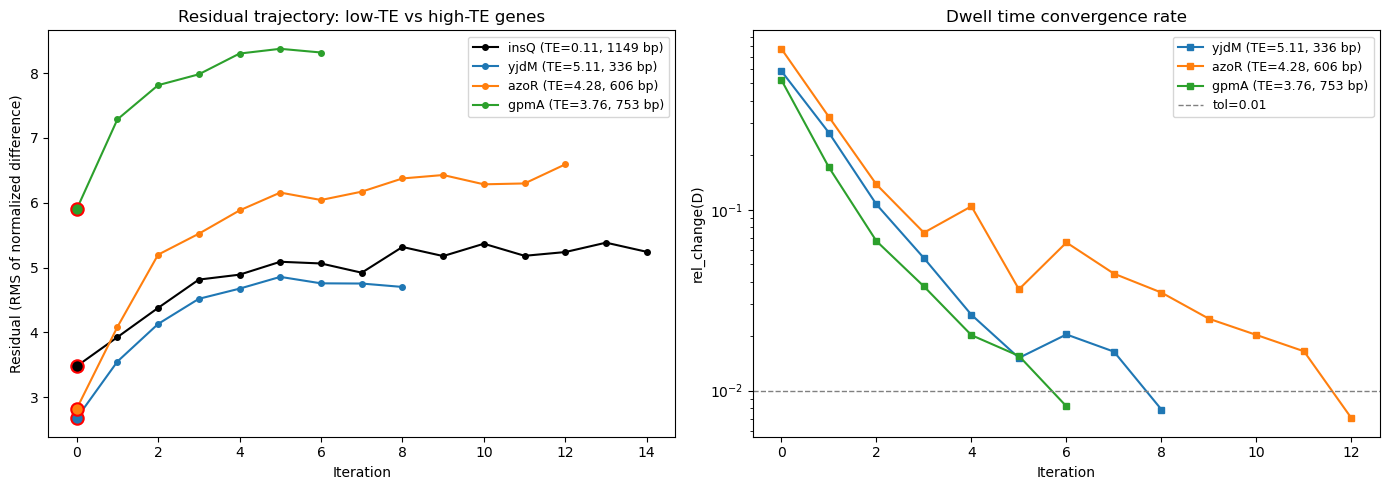

In [26]:
# Include insQ results from the earlier run
insQ_results = {
    "gene": "insQ", "gene_length": gene_length, "te": kRiboLoading * 5,
    "kRiboLoading": kRiboLoading,
    "residuals": residual_history, "rel_changes": None,  # not saved earlier
    "best_residual": best_residual, "best_iter": best_iter,
}
all_results = {"insQ": insQ_results, **results}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {"insQ": "black", "yjdM": "tab:blue", "azoR": "tab:orange", "gpmA": "tab:green"}

# --- Left panel: Residual trajectories ---
for name, r in all_results.items():
    iters = np.arange(len(r["residuals"]))
    te = r.get("te", 0)
    gl = r["gene_length"]
    label = f"{name} (TE={te:.2f}, {gl} bp)"
    axes[0].plot(iters, r["residuals"], "o-", color=colors[name], lw=1.5, markersize=4, label=label)
    axes[0].scatter([r["best_iter"]], [r["best_residual"]], color=colors[name], s=80, zorder=5, edgecolors="red", linewidths=1.5)

axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Residual (RMS of normalized difference)")
axes[0].set_title("Residual trajectory: low-TE vs high-TE genes")
axes[0].legend(fontsize=9)

# --- Right panel: Relative change in D ---
for name, r in all_results.items():
    if r.get("rel_changes") is not None:
        iters = np.arange(len(r["rel_changes"]))
        te = r.get("te", 0)
        gl = r["gene_length"]
        axes[1].plot(iters, r["rel_changes"], "s-", color=colors[name], lw=1.5, markersize=4, label=f"{name} (TE={te:.2f}, {gl} bp)")

axes[1].axhline(0.01, color="gray", ls="--", lw=1, label="tol=0.01")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("rel_change(D)")
axes[1].set_title("Dwell time convergence rate")
axes[1].legend(fontsize=9)
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [27]:
# Summary table
print(f"{'Gene':<8} {'TE':>6} {'kRibo':>7} {'Length':>6} {'Iters':>5} {'Init Res':>9} {'Best Res':>9} {'Best @':>6} {'Final Res':>10}  {'Residual trend'}")
print("-" * 95)
for name, r in all_results.items():
    res = r["residuals"]
    trend = "UP" if res[-1] > res[0] * 1.05 else ("DOWN" if res[-1] < res[0] * 0.95 else "FLAT")
    te = r.get("te", 0)
    kr = r.get("kRiboLoading", 0)
    print(f"{name:<8} {te:>6.2f} {kr:>7.3f} {r['gene_length']:>6} {len(res):>5} {res[0]:>9.4f} {r['best_residual']:>9.4f} {r['best_iter']:>6} {res[-1]:>10.4f}  {trend}")

Gene         TE   kRibo Length Iters  Init Res  Best Res Best @  Final Res  Residual trend
-----------------------------------------------------------------------------------------------
insQ       0.11   0.022   1149    15    3.4782    3.4782      0     5.2433  UP
yjdM       5.11   1.022    336     9    2.6759    2.6759      0     4.7015  UP
azoR       4.28   0.856    606    13    2.8212    2.8212      0     6.5931  UP
gpmA       3.76   0.752    753     7    5.8989    5.8989      0     8.3182  UP


### S_exp vs S_sim at Final (Converged) Iteration

These show what the RL iteration converged *to* — the fixed point of the update map, not the best-fit iteration (which is always iter 0).

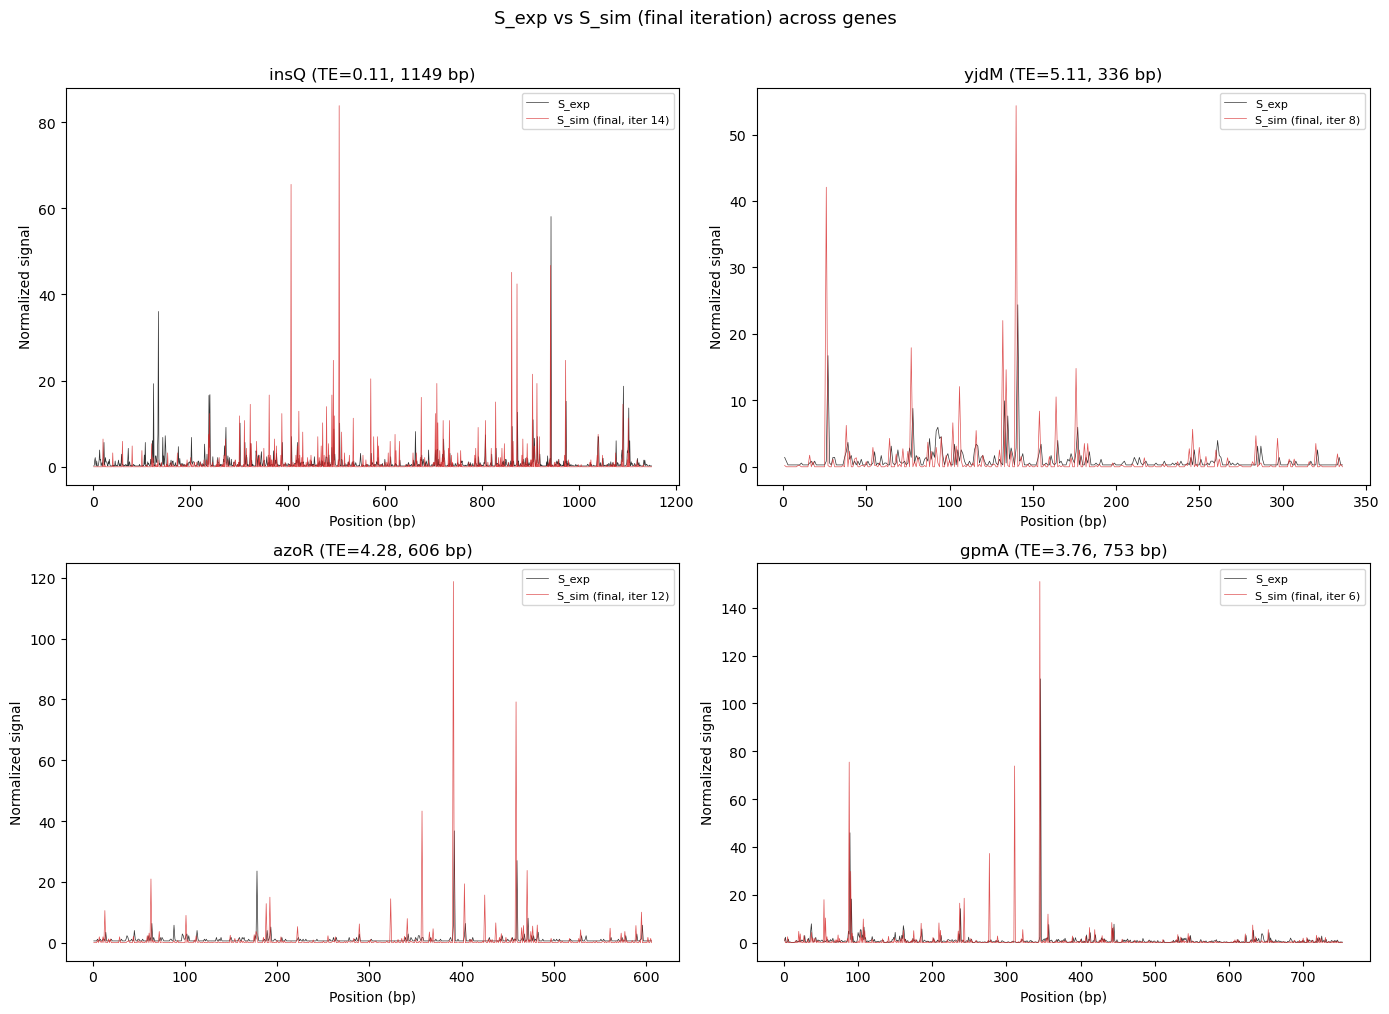

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

n_iters_insQ = len(residual_history) - 1  # last iteration index

# insQ: S_sim_norm from cell-12 is the last iteration's value
# high-TE genes: S_sim_final from updated run_rl_deconvolution
plot_data = [
    ("insQ", S_exp_norm, S_sim_norm, gene_length, kRiboLoading * 5, n_iters_insQ),
    ("yjdM", results["yjdM"]["S_exp"], results["yjdM"]["S_sim_final"], results["yjdM"]["gene_length"], results["yjdM"]["te"], len(results["yjdM"]["residuals"]) - 1),
    ("azoR", results["azoR"]["S_exp"], results["azoR"]["S_sim_final"], results["azoR"]["gene_length"], results["azoR"]["te"], len(results["azoR"]["residuals"]) - 1),
    ("gpmA", results["gpmA"]["S_exp"], results["gpmA"]["S_sim_final"], results["gpmA"]["gene_length"], results["gpmA"]["te"], len(results["gpmA"]["residuals"]) - 1),
]

for ax, (name, s_exp, s_sim, gl, te, last_it) in zip(axes, plot_data):
    pos = np.arange(1, gl + 1)
    ax.plot(pos, s_exp, lw=0.5, alpha=0.8, color="black", label="S_exp")
    ax.plot(pos, s_sim, lw=0.5, alpha=0.8, color="tab:red", label=f"S_sim (final, iter {last_it})")
    ax.set_title(f"{name} (TE={te:.2f}, {gl} bp)")
    ax.set_xlabel("Position (bp)")
    ax.set_ylabel("Normalized signal")
    ax.legend(fontsize=8)

plt.suptitle("S_exp vs S_sim (final iteration) across genes", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()